# Transform

Do imports.

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from ae483tools import *

Load data from a flight in which the drone took off, moved in a square, and landed.

In [2]:
raw_data_drone, raw_data_mocap = load_hardware_data('square.json')

Resample drone data.

In [3]:
data_drone = resample_data_drone(raw_data_drone, t_min_offset=0., t_max_offset=0.)

t = data_drone['time']
x_drone = data_drone['stateEstimate.x']
y_drone = data_drone['stateEstimate.y']
z_drone = data_drone['stateEstimate.z']
psi_drone = np.deg2rad(data_drone['stateEstimate.yaw'])
theta_drone = - np.deg2rad(data_drone['stateEstimate.pitch'])
phi_drone = np.deg2rad(data_drone['stateEstimate.roll'])

Resample mocap data.

In [4]:
resampled_data_mocap = resample_data_mocap(raw_data_mocap, t)

x_mocap = resampled_data_mocap['x']
y_mocap = resampled_data_mocap['y']
z_mocap = resampled_data_mocap['z']
psi_mocap = resampled_data_mocap['yaw']
theta_mocap = resampled_data_mocap['pitch']
phi_mocap = resampled_data_mocap['roll']

Plot $x, y$ data.

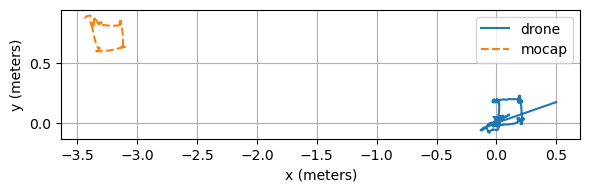

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
ax.plot(x_drone, y_drone, label='drone')
ax.plot(x_mocap, y_mocap, '--', label='mocap')
ax.legend()
ax.grid()
ax.set_aspect('equal')
ax.set_xlabel('x (meters)')
ax.set_ylabel('y (meters)')
plt.show()

In [6]:
def rotation_matrix(roll, pitch, yaw):

    # Rotation matrix around the x-axis (roll)
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(roll), -np.sin(roll)],
                    [0, np.sin(roll), np.cos(roll)]])
    
    # Rotation matrix around the y-axis (pitch)
    R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                    [0, 1, 0],
                    [-np.sin(pitch), 0, np.cos(pitch)]])
    
    # Rotation matrix around the z-axis (yaw)
    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])

    # Combined rotation matrix R = R_z * R_y * R_x
    R = R_x @ R_y @ R_z

    return R

In [7]:
def euler_from_rotation_matrix(R):
    """
    Extract roll, pitch, and yaw from a given 3x3 rotation matrix.
    
    This assumes a ZYX (yaw-pitch-roll) intrinsic rotation order.
    
    Args:
    - R: 3x3 rotation matrix
    
    Returns:
    - roll, pitch, yaw angles (in radians)
    """
    
    # Check if pitch is near +/-90 degrees (singularity)
    if abs(R[2, 0]) != 1:
        pitch = -np.arcsin(R[2, 0])
        roll = np.arctan2(R[2, 1] / np.cos(pitch), R[2, 2] / np.cos(pitch))
        yaw = np.arctan2(R[1, 0] / np.cos(pitch), R[0, 0] / np.cos(pitch))
    else:
        # Gimbal lock case
        yaw = 0
        if R[2, 0] == -1:
            pitch = np.pi / 2
            roll = yaw + np.arctan2(R[0, 1], R[0, 2])
        else:
            pitch = -np.pi / 2
            roll = -yaw + np.arctan2(-R[0, 1], -R[0, 2])
    
    return roll, pitch, yaw

Define a function to perform coordinate transformation.

In [16]:
def transform_data_mocap(raw_data):
    # Copy raw data
    data = {}
    for key, val in raw_data.items():
        data[key] = val.copy()

    # Define parameters
    d_1 = 0.02314 # <-- FIXME
    d_2 = 0.00217 # <-- FIXME
    
    # Pose of drone body frame in active marker frame
    R_inA_ofB = np.eye(3)                   # <-- FIXME
    p_inA_ofB = np.array([0., 0., -d_1])      # <-- FIXME

    ####################################
    # START OF ANALYSIS AT TIME STEP 0
    #
    
    # Pose of drone world frame in active marker frame
    R_inA_ofW = np.eye(3)                 # <-- FIXME
    p_inA_ofW = -np.array([0., 0., d_1+d_2])     # <-- FIXME

    # Get measurements of (x, y, z) and (psi, theta, phi) from mocap
    x, y, z = data['x'][0], data['y'][0], data['z'][0]
    psi, theta, phi = data['yaw'][0], data['pitch'][0], data['roll'][0]

    # Pose of active marker frame in mocap world frame
    R_inQ_ofA = Rotation.from_euler('ZYX', [psi, theta, phi]).as_matrix()
    p_inQ_ofA = np.array([x, y, z])
    
    # Pose of drone world frame in mocap world frame
    R_inQ_ofW = R_inQ_ofA @ R_inA_ofW
    p_inQ_ofW = p_inQ_ofA + R_inQ_ofA @ (p_inA_ofW)
    
    # Pose of mocap world frame in drone world frame
    R_inW_ofQ = R_inQ_ofW.T
    p_inW_ofQ = -(R_inW_ofQ@p_inQ_ofW)

    #
    # END OF ANALYSIS AT TIME STEP 0
    ####################################

    for i in range(len(data['time'])):

        ####################################
        # START OF ANALYSIS AT TIME STEP i
        #

        # Get measurements of (x, y, z) and (psi, theta, phi) from mocap
        x, y, z = data['x'][i], data['y'][i], data['z'][i]
        psi, theta, phi = data['yaw'][i], data['pitch'][i], data['roll'][i]

        # Pose of active marker deck in mocap world frame
        R_inQ_ofA = Rotation.from_euler('ZYX', [psi, theta, phi]).as_matrix()
        p_inQ_ofA = np.array([x, y, z])

        # Pose of drone body frame in drone world frame
        R_inW_ofB = R_inW_ofQ @ R_inQ_ofA @ R_inA_ofB
        p_inW_ofB = p_inW_ofQ + R_inW_ofQ @ (p_inQ_ofA + R_inQ_ofA @ p_inA_ofB)

        # Replace measurements of (x, y, z) and (phi, theta, psi) from mocap
        data['x'][i], data['y'][i], data['z'][i] = p_inW_ofB
        R = Rotation.from_matrix(R_inW_ofB)
        data['yaw'][i], data['pitch'][i], data['roll'][i] = R.as_euler('ZYX', degrees=False)

        #
        # END OF ANALYSIS AT TIME STEP i
        ####################################
        # print(p_inW_ofB)
    # Return the result
    return data

Apply coordinate transformation to mocap data.

In [17]:
transformed_data_mocap = transform_data_mocap(resampled_data_mocap)

x_mocap = transformed_data_mocap['x']
y_mocap = transformed_data_mocap['y']
z_mocap = transformed_data_mocap['z']
psi_mocap = transformed_data_mocap['yaw']
theta_mocap = transformed_data_mocap['pitch']
phi_mocap = transformed_data_mocap['roll']

Plot $x, y$ data.

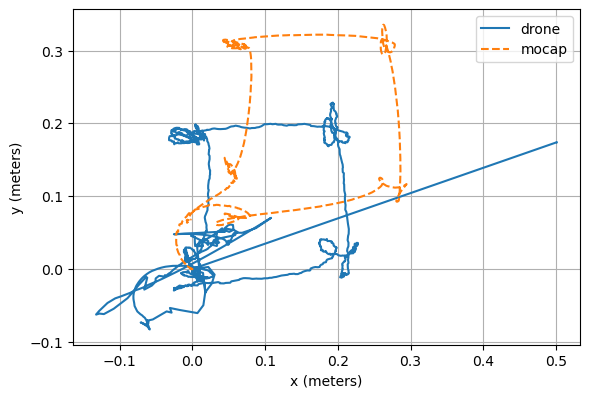

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
ax.plot(x_drone, y_drone, label='drone')
ax.plot(x_mocap, y_mocap, '--', label='mocap')
ax.legend()
ax.grid()
ax.set_aspect('equal')
ax.set_xlabel('x (meters)')
ax.set_ylabel('y (meters)')
plt.show()

Plot all data.

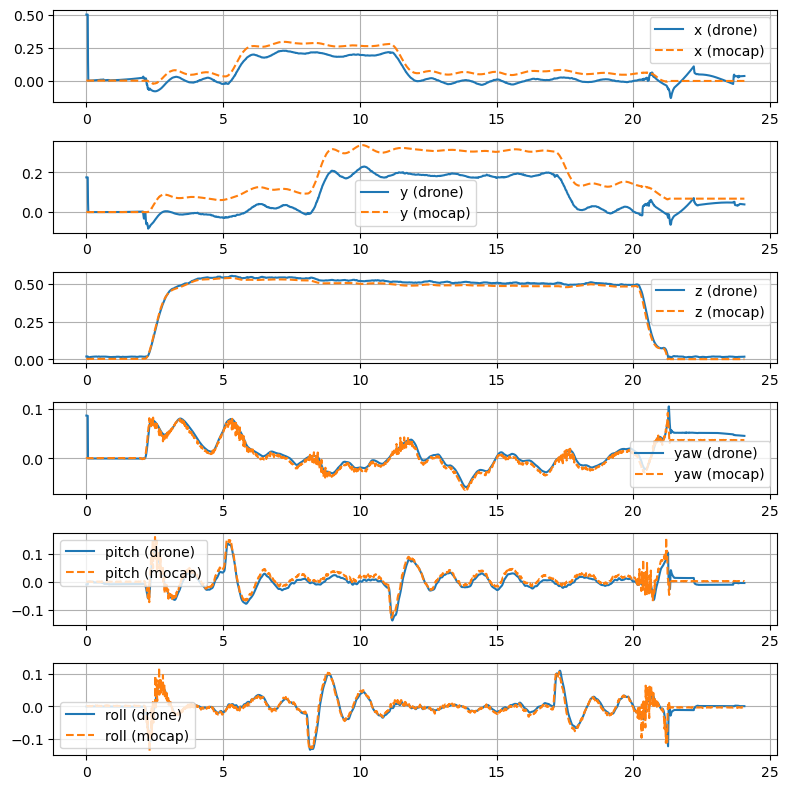

In [19]:
fig, (ax_x, ax_y, ax_z, ax_psi, ax_theta, ax_phi) = plt.subplots(6, 1, figsize=(8, 8), tight_layout=True)

ax_x.plot(t, x_drone, label='x (drone)')
ax_x.plot(t, x_mocap, '--', label='x (mocap)')
ax_x.legend()
ax_x.grid()

ax_y.plot(t, y_drone, label='y (drone)')
ax_y.plot(t, y_mocap, '--', label='y (mocap)')
ax_y.legend()
ax_y.grid()

ax_z.plot(t, z_drone, label='z (drone)')
ax_z.plot(t, z_mocap, '--', label='z (mocap)')
ax_z.legend()
ax_z.grid()

ax_psi.plot(t, psi_drone, label='yaw (drone)')
ax_psi.plot(t, psi_mocap, '--', label='yaw (mocap)')
ax_psi.legend()
ax_psi.grid()

ax_theta.plot(t, theta_drone, label='pitch (drone)')
ax_theta.plot(t, theta_mocap, '--', label='pitch (mocap)')
ax_theta.legend()
ax_theta.grid()

ax_phi.plot(t, phi_drone, label='roll (drone)')
ax_phi.plot(t, phi_mocap, '--', label='roll (mocap)')
ax_phi.legend()
ax_phi.grid()

plt.show()